<a href="https://colab.research.google.com/github/ivanpalenciab/prediccion-precio-maiz/blob/master/red_neuronal_densa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

#modulos sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#modulos keras
from keras.models import Sequential
from keras.layers import Dense,Flatten

In [ ]:
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/descompocion-ensamble/emd_modes/residuo.csv")
modo_4["Fecha"] = pd.to_datetime(modo_4["Fecha"],format='%Y-%m-%d')
modo_5["Fecha"] = pd.to_datetime(modo_5["Fecha"],format='%Y-%m-%d')
residuo["Fecha"] = pd.to_datetime(residuo["Fecha"],format='%Y-%m-%d')
modo_4.set_index("Fecha", inplace=True)
modo_5.set_index("Fecha", inplace=True)
residuo.set_index("Fecha", inplace=True)

In [ ]:
modo_4 = modo_4.asfreq('D')
modo_5 = modo_5.asfreq('D')
residuo = residuo.asfreq('D')
modo_4.interpolate(inplace=True)
modo_5.interpolate(inplace=True)
residuo.interpolate(inplace=True)

<Axes: xlabel='Fecha'>

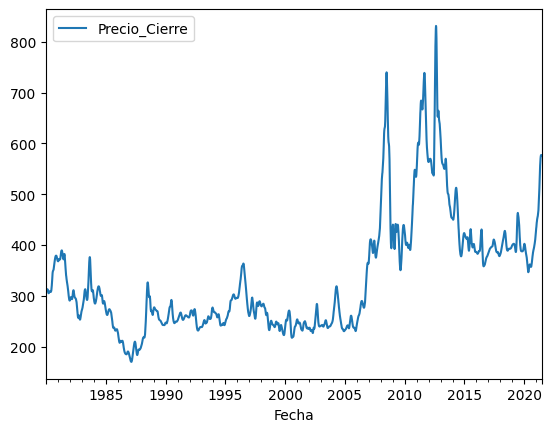

In [ ]:
datos_emd = modo_4 + modo_5 + residuo
datos_emd.plot()

In [ ]:
datos_emd.describe()

,Precio_Cierre
count,15155.000000
mean,334.184517
std,114.838858
min,169.950182
25%,249.239277
50%,291.042033
75%,394.196595
max,831.128743


In [ ]:
#agregar características de retraso al conjunto de datos
def add_lags(df,pasos):
    target_map = df['Precio_Cierre'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = (df.index - pd.Timedelta(f'{i} days')).map(target_map)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

# modelamos modo 4


In [ ]:
# de pasos que vamos a utilizar para convertir nuestra serie de tiempo a aprendizaje supervizado
PASOS = 7

In [ ]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = add_lags(modo_4_escalado, PASOS)
modo_4_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982,-0.046625,-0.039828
1980-01-10,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982,-0.046625
1980-01-11,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141,-0.052982
1980-01-12,-0.069320,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300,-0.054141
1980-01-13,-0.070446,-0.069320,-0.068195,-0.063889,-0.058778,-0.057618,-0.056459,-0.055300


In [ ]:
total_datos=len(modo_4_sup)
#modo_4_sup = modo_4_sup.values
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

datos_entrenamiento_m4_values= datos_entrenamiento_m4.values
datos_validacion_m4_values = datos_validacion_m4.values
datos_testeo_m4_values = datos_testeo_m4.values

X_train, y_train = datos_entrenamiento_m4_values[:, :-1], datos_entrenamiento_m4_values[:, -1]
X_val, y_val = datos_validacion_m4_values[:, :-1], datos_validacion_m4_values[:, -1]
X_test, y_test = datos_testeo_m4_values[:, :-1], datos_testeo_m4_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


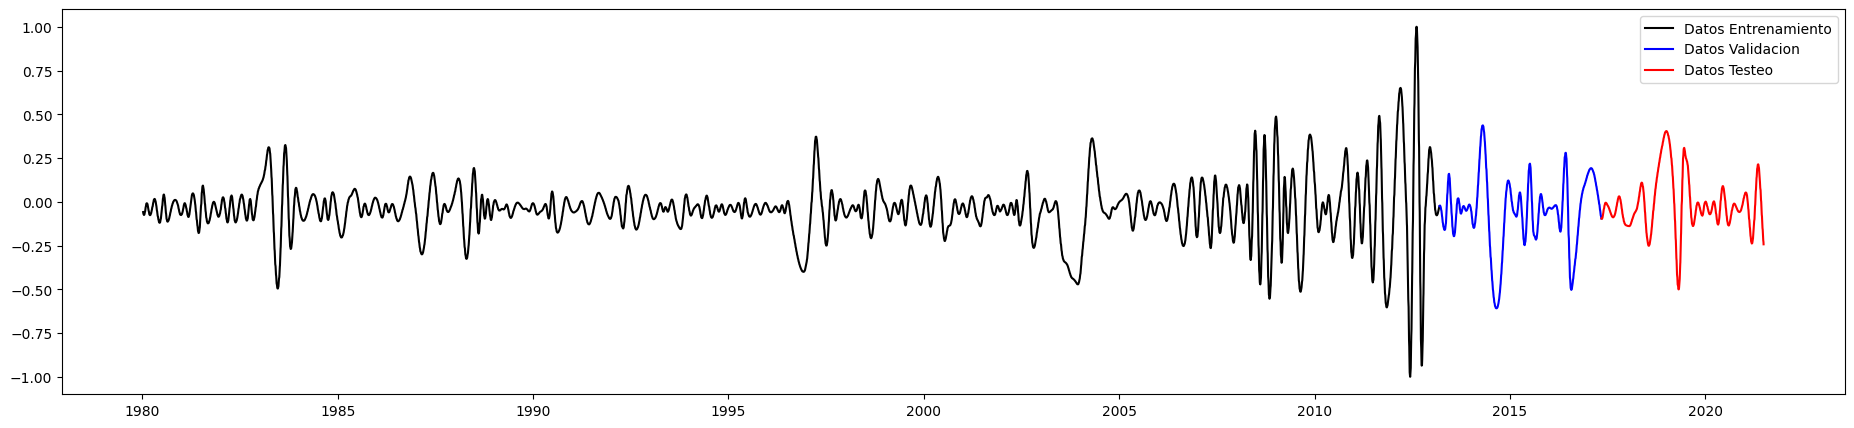

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
def modeloRD():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh'))
  modelo.add(Flatten())
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo


In [ ]:
modelo = modeloRD()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 4s 2ms/step - loss: 9.8296e-04
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.5899e-04
Epoch 3/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.2114e-04
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.0170e-04
Epoch 5/40
1732/1732 [==============================] - 4s 2ms/step - loss: 8.8829e-05
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 7.7770e-05
Epoch 7/40
1732/1732 [==============================] - 3s 2ms/step - loss: 6.8330e-05
Epoch 8/40
1732/1732 [==============================] - 3s 1ms/step - loss: 6.0829e-05
Epoch 9/40
1732/1732 [==============================] - 3s 2ms/step - loss: 5.4810e-05
Epoch 10/40
1732/1732 [==============================] - 4s 2ms/step - loss: 4.8748e-05
Epoch 11/40
1732/1732 [==============================] - 3s 2ms/step - loss: 4.5646e-05
Epoch 12/40
1732/1732 [==================

In [ ]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 7)              56        
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 8         
                                                                 
Total params: 64 (256.00 Byte)
Trainable params: 64 (256.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
prediccion_validacion_m4 = modelo.predict(X_val)
prediccion_testeo_m4 = modelo.predict(X_test)

48/48 [==============================] - 0s 2ms/step


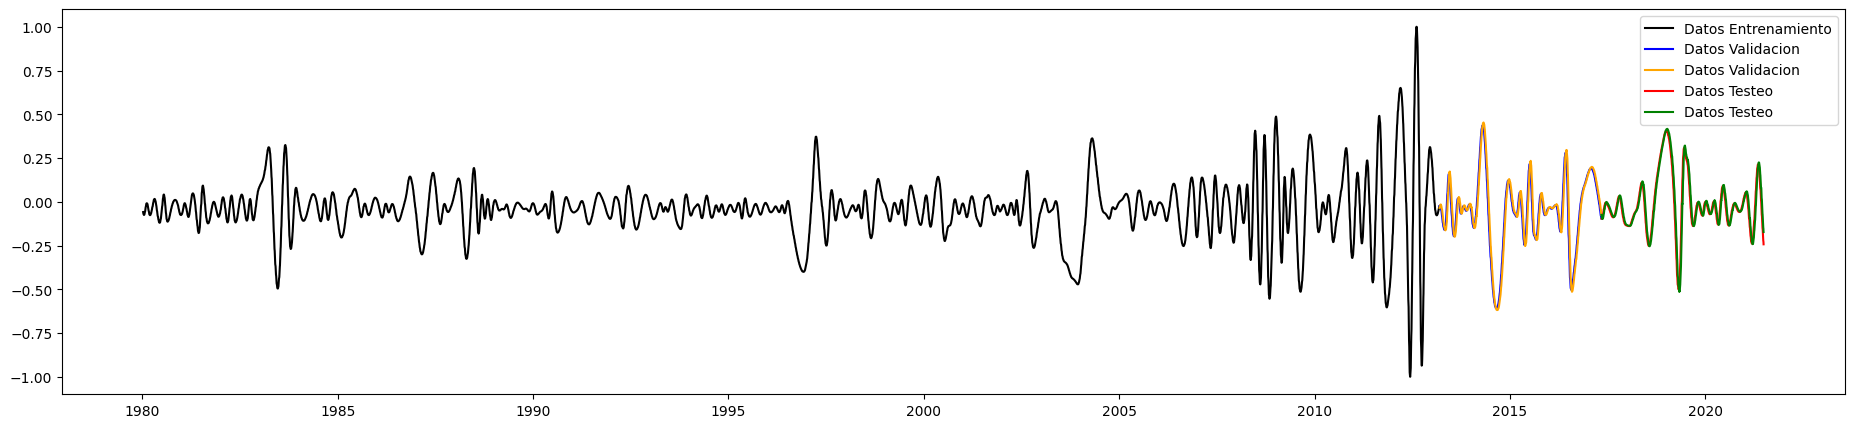

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m4.index,prediccion_validacion_m4,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m4.index,prediccion_testeo_m4,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(prediccion_validacion_m4,datos_validacion_m4.Precio_Cierre))
print(score)

0.04929718


In [ ]:
prediccion_validacion_m4 = modo_4_scaler.inverse_transform(prediccion_validacion_m4)
prediccion_testeo_m4 = modo_4_scaler.inverse_transform(prediccion_testeo_m4 )

# Modelamos modo 5

In [ ]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = add_lags(modo_5_escalado, PASOS)
modo_5_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360,0.104982,0.106591
1980-01-10,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360,0.104982
1980-01-11,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032,0.103360
1980-01-12,0.097843,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705,0.103032
1980-01-13,0.097282,0.097843,0.098404,0.100071,0.101723,0.102050,0.102378,0.102705


In [ ]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values
datos_validacion_m5_values = datos_validacion_m5.values
datos_testeo_m5_values = datos_testeo_m5.values

X_train, y_train = datos_entrenamiento_m5_values[:, :-1], datos_entrenamiento_m5_values[:, -1]
X_val, y_val = datos_validacion_m5_values[:, :-1], datos_validacion_m5_values[:, -1]
X_test, y_test = datos_testeo_m5_values[:, :-1], datos_testeo_m5_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


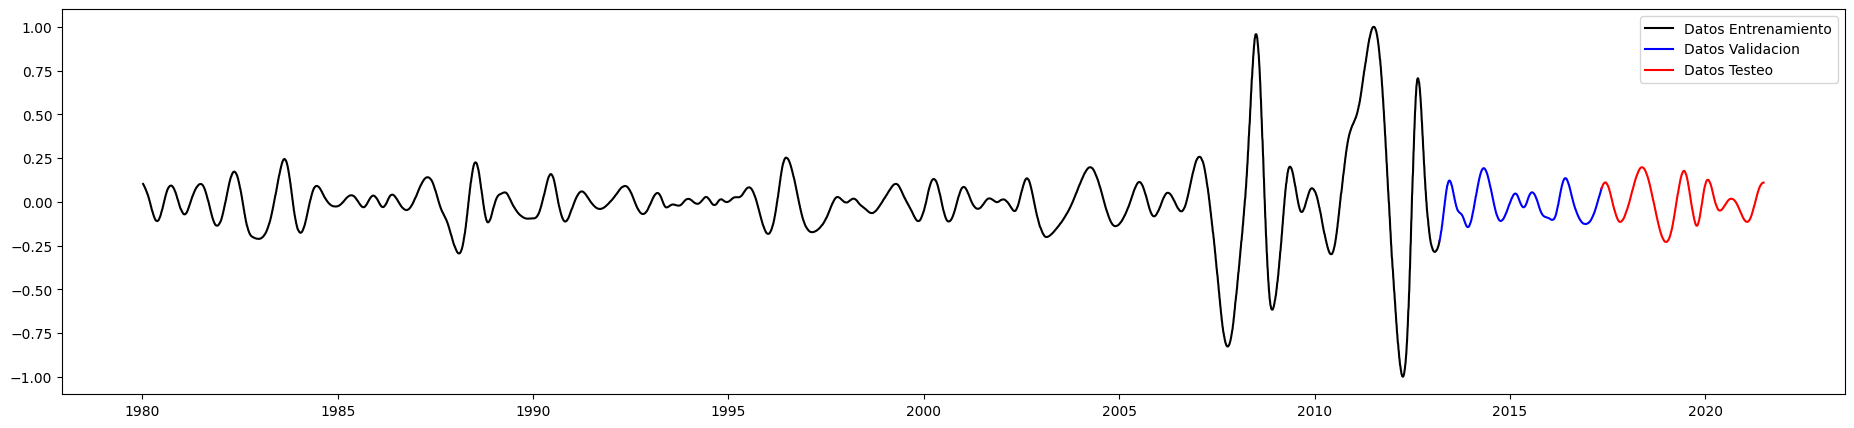

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
modelo = modeloRD()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 4s 2ms/step - loss: 0.0072
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 9.4365e-05
Epoch 3/40
1732/1732 [==============================] - 3s 2ms/step - loss: 4.9779e-05
Epoch 4/40
1732/1732 [==============================] - 3s 2ms/step - loss: 4.0748e-05
Epoch 5/40
1732/1732 [==============================] - 3s 2ms/step - loss: 3.3432e-05
Epoch 6/40
1732/1732 [==============================] - 4s 2ms/step - loss: 2.5894e-05
Epoch 7/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.5342e-05
Epoch 8/40
1732/1732 [==============================] - 3s 1ms/step - loss: 2.4859e-05
Epoch 9/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.3649e-05
Epoch 10/40
1732/1732 [==============================] - 3s 2ms/step - loss: 2.3762e-05
Epoch 11/40
1732/1732 [==============================] - 4s 2ms/step - loss: 2.3568e-05
Epoch 12/40
1732/1732 [======================

In [ ]:
prediccion_validacion_m5 = modelo.predict(X_val)
prediccion_testeo_m5 = modelo.predict(X_test)

48/48 [==============================] - 0s 3ms/step


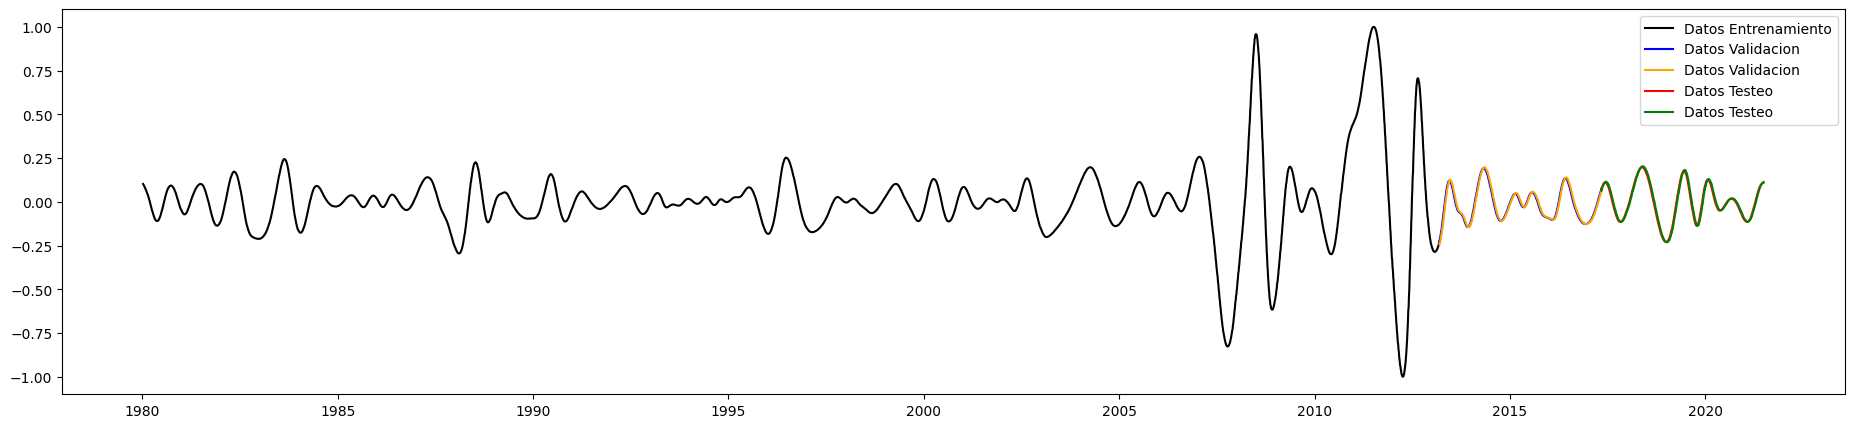

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,prediccion_validacion_m5,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_testeo_m5,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
prediccion_validacion_m5 = modo_5_scaler.inverse_transform(prediccion_validacion_m5)
prediccion_testeo_m5 = modo_5_scaler.inverse_transform(prediccion_testeo_m5 )

# Modelamos Residuo

In [ ]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,Precio_Cierre,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
Fecha,,,,,,,,
1980-01-09,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891,-0.499712,-0.500525
1980-01-10,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891,-0.499712
1980-01-11,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725,-0.498891
1980-01-12,-0.496103,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560,-0.498725
1980-01-13,-0.495820,-0.496103,-0.496386,-0.497228,-0.498063,-0.498229,-0.498394,-0.498560


In [ ]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

datos_entrenamiento_residuo_values= datos_entrenamiento_residuo.values
datos_validacion_residuo_values = datos_validacion_residuo.values
datos_testeo_residuo_values = datos_testeo_residuo.values

X_train, y_train = datos_entrenamiento_residuo_values[:, :-1], datos_entrenamiento_residuo_values[:, -1]
X_val, y_val = datos_validacion_residuo_values[:, :-1], datos_validacion_residuo_values[:, -1]
X_test, y_test = datos_testeo_residuo_values[:, :-1], datos_testeo_residuo_values[:, -1]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape , y_test.shape)

(12118, 1, 7) (12118,) (1514, 1, 7) (1514,) (1516, 1, 7) (1516,)


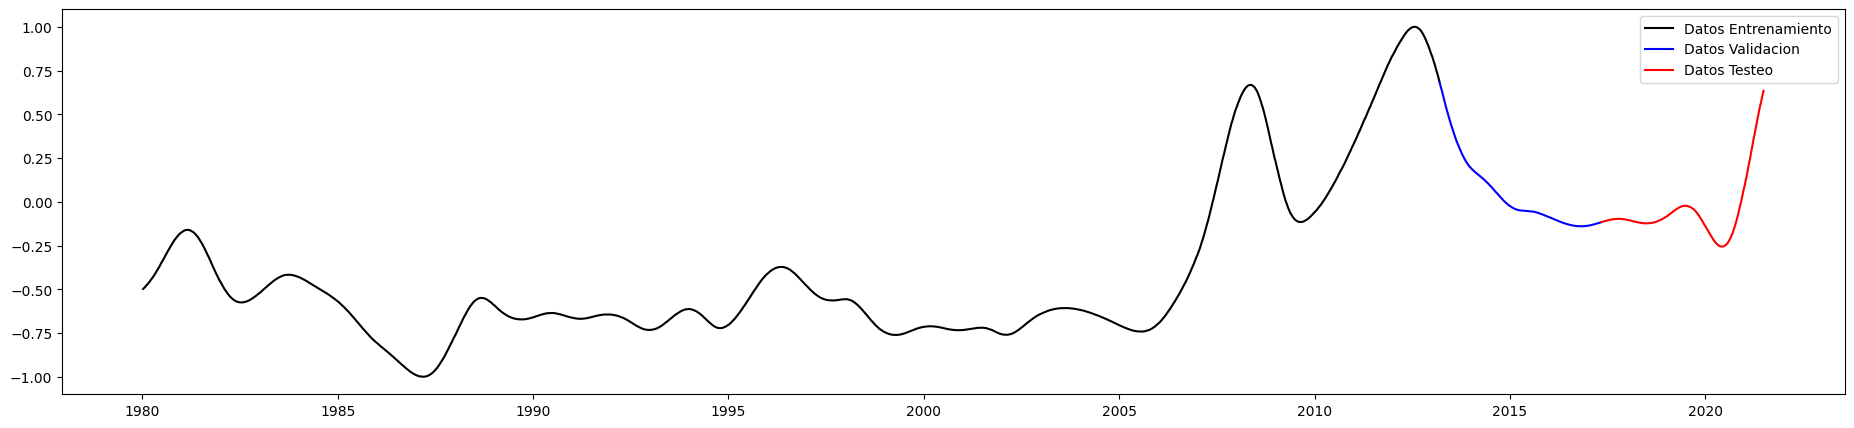

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
def modeloRR_residuo():
  modelo = Sequential()
  modelo.add(Dense(units=PASOS, input_shape=(1,PASOS), activation='tanh', return_sequences=True))
  modelo.add(Dense(units=50, activation='tanh'))
  modelo.add(Dense(units=1))
  modelo.compile(optimizer='rmsprop', loss='mse')
  return modelo

In [ ]:
modelo = modeloRD()
modelo.fit(X_train,y_train,epochs=40,batch_size=7)

Epoch 1/40
1732/1732 [==============================] - 3s 2ms/step - loss: 7.0312e-04
Epoch 2/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.3442e-04
Epoch 3/40
1732/1732 [==============================] - 3s 2ms/step - loss: 1.0563e-04
Epoch 4/40
1732/1732 [==============================] - 4s 2ms/step - loss: 9.5159e-05
Epoch 5/40
1732/1732 [==============================] - 3s 2ms/step - loss: 9.2000e-05
Epoch 6/40
1732/1732 [==============================] - 3s 2ms/step - loss: 8.8160e-05
Epoch 7/40
1732/1732 [==============================] - 3s 2ms/step - loss: 8.5740e-05
Epoch 8/40
1732/1732 [==============================] - 3s 2ms/step - loss: 8.3028e-05
Epoch 9/40
1732/1732 [==============================] - 4s 2ms/step - loss: 8.0226e-05
Epoch 10/40
1732/1732 [==============================] - 3s 2ms/step - loss: 7.8451e-05
Epoch 11/40
1732/1732 [==============================] - 3s 2ms/step - loss: 7.6028e-05
Epoch 12/40
1732/1732 [==================

In [ ]:
prediccion_validacion_residuo = modelo.predict(X_val)
prediccion_testeo_residuo = modelo.predict(X_test)

48/48 [==============================] - 0s 1ms/step


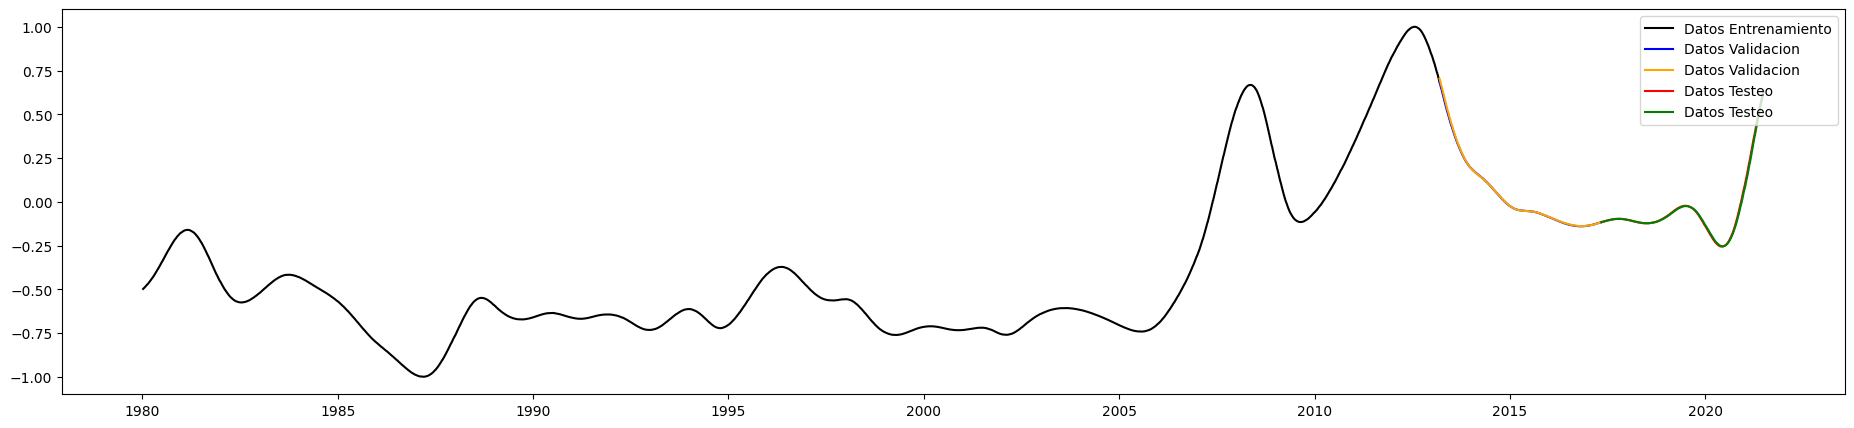

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,prediccion_validacion_residuo,color='orange',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_testeo_residuo,color='green',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
prediccion_validacion_residuo = residuo_scaler.inverse_transform(prediccion_validacion_residuo)
prediccion_testeo_residuo = residuo_scaler.inverse_transform(prediccion_testeo_residuo  )

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [ ]:
datos_emd
validacion = prediccion_validacion_m4 + prediccion_validacion_m5 +  prediccion_validacion_residuo
testeo = prediccion_testeo_m4 + prediccion_testeo_m5 + prediccion_testeo_residuo

In [ ]:
total_datos=len(datos_emd.Precio_Cierre)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

In [ ]:
recm_validacion = np.sqrt(mean_squared_error( validacion,datos_validacion.Precio_Cierre))
eam_validacion = mean_absolute_error( validacion,datos_validacion.Precio_Cierre)
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

ValueError: Found input variables with inconsistent numbers of samples: [1514, 1515]

In [ ]:
recm = np.sqrt(mean_squared_error( testeo,datos_testeo.Precio_Cierre))
eam = mean_absolute_error( testeo,datos_testeo.Precio_Cierre)
EPAM = mean_absolute_percentage_error(testeo,datos_testeo.Precio_Cierre)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 3.9310405444391443 
el error absoluto medio del modelo es: 2.7750585185368757 
Error porcentual absoluto medio del modelo es: 0.006606706020034123


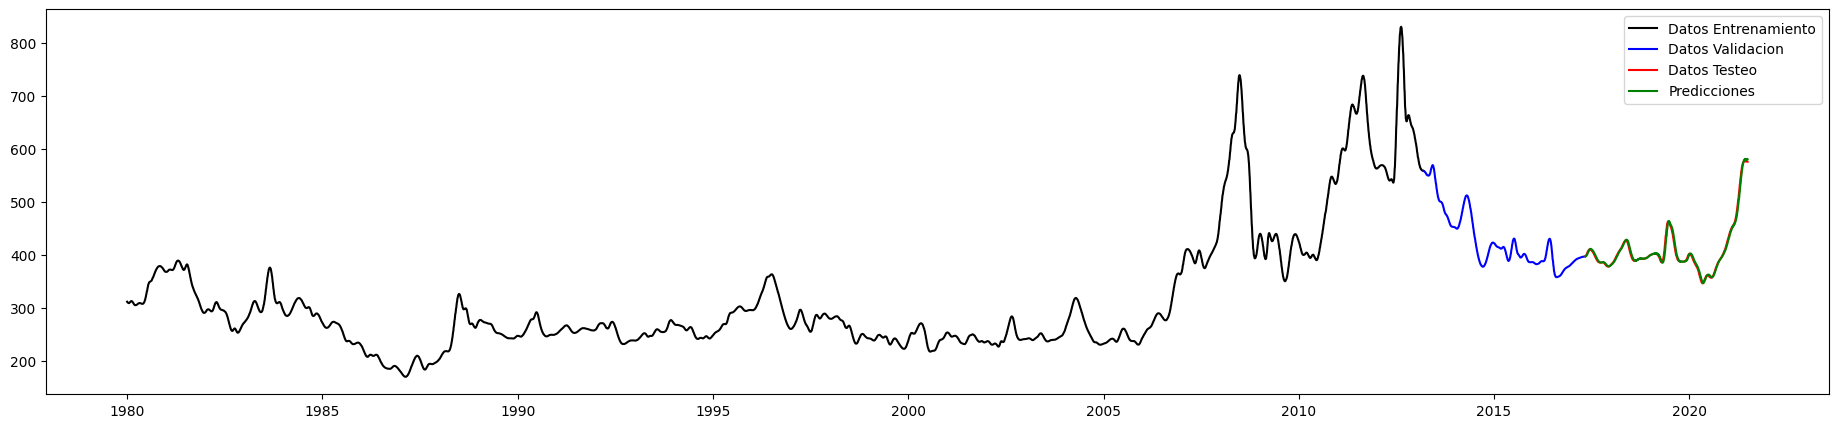

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.Precio_Cierre,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.Precio_Cierre,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

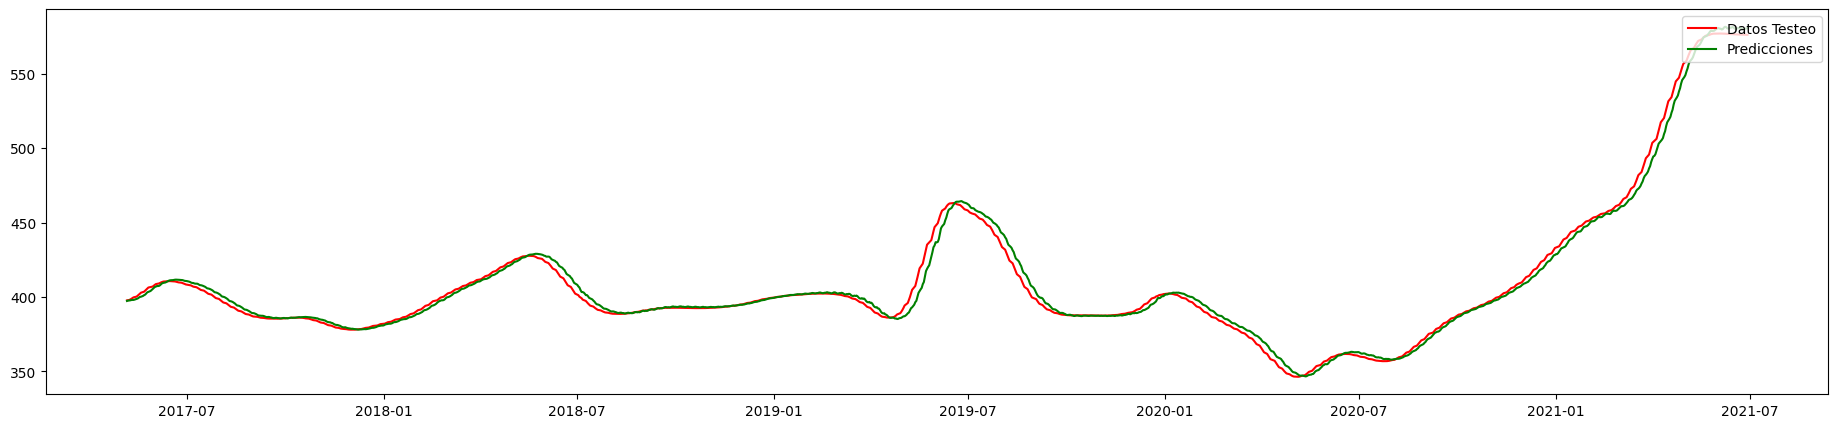

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.Precio_Cierre,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,testeo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()